In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
sys.path.insert(0,'..')
from cider.home_location import *

config_file = '../configs/config_new.yml'

### Load from datastore

In [7]:
datastore = DataStore(config_file)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/05 01:02:31 WARN Utils: Your hostname, Poornimas-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.14 instead (on interface en0)
25/11/05 01:02:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/05 01:02:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/05 01:02:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [8]:
setattr(datastore, "outputs", str(datastore.cfg.path.working.directory_path))

In [9]:
spark = datastore.spark
home_locator = HomeLocator(datastore)


Fpath: /Users/poornimaramesh/Documents/IDinsight/GiveDirectly_x_Safaricom/cider/synthetic_data/cdr.csv
Loading CDR...
Loading antennas...


In [10]:
cdr = pd.read_csv('../synthetic_data/cdr.csv')
outgoing = cdr[['caller_id', 'caller_antenna', 'timestamp']]\
    .rename({'caller_id':'name', 'caller_antenna':'antenna_id'}, axis=1)
incoming = cdr[['recipient_id', 'recipient_antenna', 'timestamp']]\
    .rename({'recipient_id':'name', 'recipient_antenna':'antenna_id'}, axis=1)
cdr = pd.concat([outgoing, incoming])
antennas = pd.read_csv('../synthetic_data/antennas.csv')
cdr = cdr.merge(antennas, on='antenna_id', how='inner')
home_locations_gt = pd.read_csv('../synthetic_data/home_locations.csv')


In [11]:
shapefile = gpd.read_file('../synthetic_data/regions.geojson')

In [ ]:
shapefile

### Modal Tower

In [ ]:
homes = home_locator.get_home_locations(geo="antenna_id", algo='count_transactions').rename({'subscriber_id':'name'}, axis=1)

In [4]:
from cider.homelocation.inference import get_home_locations
from cider.homelocation.schemas import GeographicUnit, GetHomeLocationAlgorithm

In [12]:
cdr.rename(columns={"name": "caller_id", "antenna_id": "caller_antenna_id"}, inplace=True)
antennas.rename(columns={"tower_id": "old_tower_id"}, inplace=True)
antennas["tower_id"] = antennas["antenna_id"]

In [14]:
homes_2 = get_home_locations(
    spark_session=spark,
    validated_cdr_data=cdr,
    validated_antenna_data=antennas,
    shapefile_data=shapefile,
    geographic_unit=GeographicUnit.ANTENNA_ID,
    algorithm=GetHomeLocationAlgorithm.COUNT_MODAL_DAYS,
    # additional_columns_to_keep=["region"],
)

In [17]:
home_locations_gt.rename(
    columns={
        "subscriber_id": "caller_id",
        "antenna_id": "caller_antenna_id",
        "regions": "region"}, 
    inplace=True)

In [11]:
homes_2.head()

,caller_id,caller_antenna_id,transaction_modal_days_count,region
0,180002964,a260,2,PLATEAUX
1,180013658,a230,3,PLATEAUX
2,180025080,a220,2,CENTRALE
3,180029327,a178,2,SAVANES
4,180050817,a29,2,MARITIME


In [19]:
home_locations_gt.head()

,caller_id,caller_antenna_id,tower_id,region,prefectures
0,185980061,a5,t33,MARITIME,OTI-SUD
1,180025080,a233,t24,MARITIME,OTI
2,185812337,a100,t30,KARA,AGOE-NYIVE
3,187104291,a214,t87,KARA,ASSOLI
4,189727971,a157,t0,SAVANES,BAS-MONO


In [24]:
from cider.homelocation.inference import get_accuracy

table = get_accuracy(homes_2, home_locations_gt, column_to_merge_on="caller_id", column_to_measure_on="region")

In [26]:
table.is_correct.mean()

np.float64(0.184)

In [ ]:
homes.rename(
    columns={
        "name": "caller_id", 
        "count_modal_days": "transaction_modal_days_count"}, 
        inplace=True)

In [ ]:
homes_2.drop(columns["caller_antenna_id"])

In [108]:
homes2

NameError: name 'homes2' is not defined

In [ ]:
import deepdiff
deepdiff.DeepDiff(homes.sort_values(by="caller_id").reset_index(drop=True), homes_2.sort_values(by="caller_id").reset_index(drop=True))

In [ ]:
grouped = pd.DataFrame(cdr.groupby('name')['tower_id'].agg(pd.Series.mode))
grouped['tower_id'] = grouped['tower_id'].apply(lambda x:  x if ','.join(x)[1] == ',' else np.nan)
grouped = grouped.dropna()
merged = grouped.merge(homes, on='name')
assert len(merged[merged['tower_id_x'] != merged['tower_id_y']]) == 0

### Tower with Most Unique Days

In [ ]:
homes = home_locator.get_home_locations('antenna_id', 'count_days').rename({'subscriber_id':'name'}, axis=1)

In [ ]:
cdr['day'] = cdr['timestamp'].apply(lambda x: x[:10])
grouped = pd.DataFrame(cdr.groupby(['name', 'tower_id'])['timestamp'].nunique())
max_counts = grouped.groupby('name').agg('max')
max_counts = max_counts.to_dict(orient='index')
for key in list(max_counts.keys()):
    max_counts[key] = max_counts[key]['timestamp']
grouped['c'] = [x[0] for x in list(grouped.index)]
grouped['t'] = [x[1] for x in list(grouped.index)]
grouped['max'] = grouped.apply(lambda row: 1 if row['timestamp'] == max_counts[row['c']] else 0, axis=1)
grouped = grouped[grouped['max'] == 1]
included = grouped.groupby('c').agg('count')
included = set(included[included['max'] == 1].index)
grouped = grouped[grouped['c'].isin(included)]\
    .reset_index()\
    .drop(['name', 'tower_id'], axis=1)\
    [['c', 't']].rename({'c':'name', 't':'tower_id'}, axis=1)
assert len(merged[merged['tower_id_x'] != merged['tower_id_y']]) == 0

### Mode of Modes

In [ ]:
# This one is nearly impossible to test for with the synthetic data, there are not enough unique modes so 
# it's basically random

### Maps

In [ ]:
homes = home_locator.get_home_locations('antenna_id', 'count_days').rename({'subscriber_id':'name'}, axis=1)
home_locator.map(geo='antenna_id', algo='count_days', kind='population', voronoi=False)

In [ ]:
home_locator.accuracy(geo='antenna_id',algo='count_days')
# home_locator.map(algo='count_days', kind='precision', voronoi=False)
# home_locator.map(algo='count_days', kind='recall', voronoi=False)

In [13]:
from cider.homelocation.dependencies import get_voronoi_tessellation

In [14]:
antennas

,antenna_id,old_tower_id,latitude,longitude,tower_id
0,a0,t0,7.511790,0.917174,a0
1,a1,t0,7.511790,0.917174,a1
2,a2,t0,7.511790,0.917174,a2
3,a3,t1,10.358028,0.685346,a3
4,a4,t1,10.358028,0.685346,a4
...,...,...,...,...,...
292,a292,NaN,NaN,NaN,a292
293,a293,NaN,NaN,NaN,a293
294,a294,NaN,NaN,NaN,a294
295,a295,NaN,NaN,NaN,a295


In [15]:
antennas[['latitude', 'longitude']] = antennas[['latitude', 'longitude']].drop_duplicates()

antennas_gdf = gpd.GeoDataFrame(antennas, geometry=gpd.points_from_xy(antennas.longitude, antennas.latitude), crs="EPSG:4326")

In [16]:
antennas_gdf.dropna(inplace=True)

In [17]:
antennas_gdf.within(shapefile).sum()

/var/folders/mq/6zyh6j6j1wzc58dyc13z2hr00000gn/T/ipykernel_76756/1812355425.py:1: UserWarning: The indices of the left and right GeoSeries' are not equal, and therefore they will be aligned (reordering and/or introducing missing values) before executing the operation. If this alignment is the desired behaviour, you can silence this warning by passing 'align=True'. If you don't want alignment and protect yourself of accidentally aligning, you can pass 'align=False'.
  antennas_gdf.within(shapefile).sum()


np.int64(0)

In [ ]:
new_vornoi = get_voronoi_tessellation(
    xy_points=antennas_gdf,
    boundary_shapefile=shapefile,
    points_id_col='antenna_id'
)

In [19]:
new_vornoi

,antenna_id,geometry
0,a0,"POLYGON ((0.59914 7.40513, 0.89441 7.55683, 1...."
1,a3,"POLYGON ((0.55472 10.26722, 0.53528 10.27193, ..."
2,a5,"POLYGON ((1.54949 7.04445, 1.56924 7.28306, 1...."
3,a6,"POLYGON ((0.20362 11.0561, 0.2038 11.06913, 0...."
4,a11,"POLYGON ((1.36016 6.70595, 1.34512 6.70614, 1...."
...,...,...
95,a271,"POLYGON ((1.483 8.94824, 1.44692 8.90481, 1.38..."
96,a274,"POLYGON ((0.5725 9.76305, 0.52775 9.91403, 0.5..."
97,a275,"POLYGON ((1.38333 6.2717, 1.43041 6.34387, 1.5..."
98,a278,"POLYGON ((1.25026 8.91463, 1.38848 8.89446, 1...."


In [105]:
from helpers.plot_utils import voronoi_tessellation

In [106]:
old_voronoi = voronoi_tessellation(
    points=antennas,
    shapefile=shapefile,
    key='antenna_id',
)

In [107]:
set(old_voronoi['antenna_id']) == set(new_vornoi['antenna_id'])

True

In [21]:
# Mapping
from cider.homelocation.plotting import make_location_map

In [27]:
homes_2_gdf.columns

Index(['caller_id', 'caller_antenna_id', 'transaction_modal_days_count',
       'region', 'antenna_id', 'old_tower_id', 'latitude', 'longitude',
       'tower_id', 'geometry'],
      dtype='object')

In [51]:
merged = homes_2.merge(antennas, left_on='caller_antenna_id', right_on='antenna_id', how='left')
homes_2_gdf = gpd.GeoDataFrame(
    merged,
    geometry=gpd.points_from_xy(merged.longitude, merged.latitude),
    crs="EPSG:4326"
)
fig = make_location_map(
    inferred_home_locations=homes_2_gdf,
    boundaries_shapefile=shapefile,
    column_to_plot_label='caller_antenna_id',
    column_to_plot_markersize='transaction_modal_days_count',
    color='grey'
)


/Users/poornimaramesh/Documents/IDinsight/GiveDirectly_x_Safaricom/cider/notebooks/../cider/homelocation/plotting.py:25: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  color: color to use for plotting. Overrides column_to_plot_label if provided


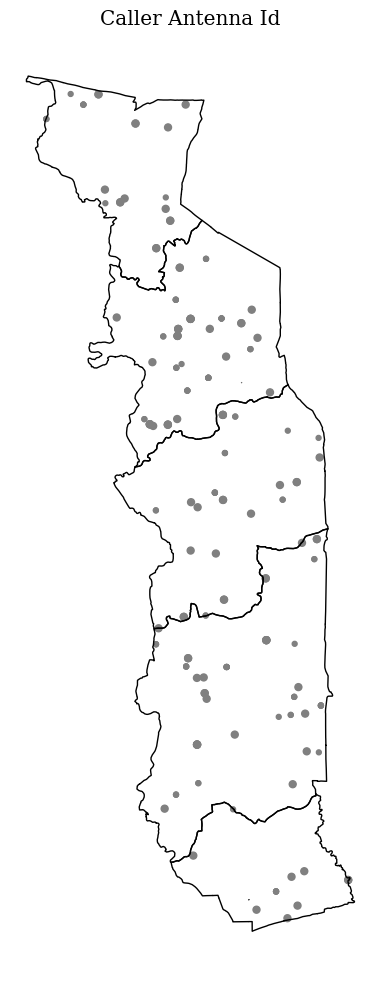